# MVP de Machine Learning — Rodrigo Szyszka Bapsita - Classificação de Spam em SMS

# Introdução
O aumento do uso de mensagens de texto trouxe também um crescimento no envio de spam, que são mensagens não solicitadas com intuito de fraude, golpes ou propagandas abusivas.

Detectar spam automaticamente é essencial para melhorar a segurança digital e a experiência dos usuários.

# Definição do Problema
Este é um problema de classificação supervisionada:
- Classe `ham` → mensagem legítima.
- Classe `spam` → mensagem indesejada.

# Objetivo
Desenvolver um modelo de aprendizado de máquina capaz de classificar automaticamente uma nova mensagem como spam ou ham, utilizando técnicas de Processamento de Linguagem Natural (NLP) e algoritmos de classificação.

## Premissas
- O dataset é representativo, contendo exemplos de spam e ham.
- Palavras, padrões de escrita e frequência de termos ajudam a diferenciar spam de ham.

# Métricas de Avaliação
- Accuracy: percentual total de acertos.
- Precision: proporção de mensagens classificadas como spam que realmente eram spam.
- Recall: proporção de spam que o modelo conseguiu identificar corretamente.
- F1-Score: equilíbrio entre precisão e recall.


In [ ]:
# Imports básicos
import pandas as pd

# URL do dataset (SMS Spam Collection)
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"

# Carregar o dataset (tsv = tab-separated values)
df = pd.read_table(url, header=None, names=["label", "message"])

# Mostrar primeiras linhas
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Analisar como os dados estão distribuidos

In [ ]:
# Verificar formato do dataset
print("Dimensões:", df.shape)

# Contagem de classes
print("\nDistribuição das classes:")
print(df["label"].value_counts())

# Percentual
print("\nPercentual por classe:")
print(df["label"].value_counts(normalize=True)*100)

# Amostra de mensagens
df.sample(10, random_state=42)


Dimensões: (5572, 2)

Distribuição das classes:
label
ham     4825
spam     747
Name: count, dtype: int64

Percentual por classe:
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


,label,message
3245,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
944,ham,And also I've sorta blown him off a couple tim...
1044,ham,Mmm thats better now i got a roast down me! i...
2484,ham,Mm have some kanji dont eat anything heavy ok
812,ham,So there's a ring that comes with the guys cos...
2973,ham,Sary just need Tim in the bollox &it hurt him ...
2991,ham,"Love isn't a decision, it's a feeling. If we c..."
2942,ham,My supervisor find 4 me one lor i thk his stud...
230,ham,Dear good morning now only i am up
1181,ham,I'm in chennai velachery:)


# Pré-processamento e Divisão do Dataset
Nesta etapa, os dados são organizados em variáveis independentes (mensagens) e variável alvo
(classe `ham` ou `spam`, convertida para valores binários 0/1).  
O conjunto é dividido em três partes: treino (70%), validação (15%) e teste (15%).  
Essa divisão permite treinar os modelos, ajustar hiperparâmetros e avaliar a capacidade de generalização
em dados não vistos.

In [16]:
# Pré-processamento e split
import numpy as np
from sklearn.model_selection import train_test_split

# Features e alvo
X = df["message"]
y = df["label"].map({"ham":0, "spam":1})  # transforma em 0/1

# Split: 70% treino, 15% validação, 15% teste
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


((3900,), (836,), (836,))

# Construção dos pipelines de modelagem  
Nesta etapa, são definidos os pipelines de processamento de texto e classificação.  
Primeiro, aplica-se o TF-IDF Vectorizer, que transforma as mensagens em vetores numéricos
ponderando a relevância de cada termo.  
Em seguida, cada pipeline combina o TF-IDF com um algoritmo de machine learning distinto:  

- Naive Bayes Multinomial: simples e eficaz para textos  
- Regressão Logística: modelo linear probabilístico  
- SVM Linear calibrado: eficiente em alta dimensionalidade, calibrado para fornecer probabilidades  
- Random Forest: ensemble de árvores de decisão, robusto e não linear  

Essa estrutura facilita a comparação entre diferentes algoritmos usando a mesma base de representação textual.


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

# Vetorizador padrão
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)

# Modelos
pipelines = {
    "NaiveBayes": Pipeline([
        ("tfidf", tfidf),
        ("model", MultinomialNB())
    ]),
    "LogReg": Pipeline([
        ("tfidf", tfidf),
        ("model", LogisticRegression(max_iter=2000, n_jobs=-1))
    ]),
    "LinearSVM": Pipeline([
        ("tfidf", tfidf),
        ("model", CalibratedClassifierCV(LinearSVC(), cv=3))  # calibrado p/ probas (AUC/ROC)
    ]),
    "RandomForest": Pipeline([
        ("tfidf", tfidf),
        ("model", RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42))
    ]),
}


#Função de avaliação dos modelos  
Foi criada uma função que treina o modelo, gera previsões e calcula métricas de desempenho.  
As métricas consideradas são: accuracy, precision, recall, F1-score e AUC (quando o modelo fornece probabilidades).  
Além disso, a função exibe a matriz de confusão, que mostra os acertos e erros entre classes,
e a curva ROC, que permite avaliar a separação entre ham e spam.  
Esse procedimento padronizado facilita a comparação entre diferentes algoritmos.


In [18]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, X_tr, y_tr, X_va, y_va, name="Model"):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_va)

    # Probabilidades para AUC (se disponível)
    try:
        y_proba = model.predict_proba(X_va)[:,1]
    except Exception:

        y_proba = None

    metrics = {
        "Modelo": name,
        "Accuracy": accuracy_score(y_va, y_pred),
        "Precision": precision_score(y_va, y_pred, zero_division=0),
        "Recall": recall_score(y_va, y_pred, zero_division=0),
        "F1": f1_score(y_va, y_pred, zero_division=0),
        "AUC": roc_auc_score(y_va, y_proba) if y_proba is not None else np.nan
    }

    # Matriz de confusão
    cm = confusion_matrix(y_va, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["ham (0)","spam (1)"], yticklabels=["ham (0)","spam (1)"])
    plt.title(f"Matriz de Confusão — {name}")
    plt.xlabel("Previsto")
    plt.ylabel("Verdadeiro")
    plt.show()

    # Curva ROC (se tiver proba)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_va, y_proba)
        plt.figure(figsize=(4,3))
        plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_va, y_proba):.3f}")
        plt.plot([0,1],[0,1], "--", color="gray")
        plt.xlabel("Falso Positivo")
        plt.ylabel("Verdadeiro Positivo")
        plt.title(f"Curva ROC — {name}")
        plt.legend()
        plt.show()

    return metrics


#Treinamento e comparação dos modelos  
Cada pipeline definido anteriormente é treinado com a base de treino e avaliado na base de validação.  
Os resultados das métricas são armazenados em uma tabela, permitindo a comparação direta entre os modelos.  
A ordenação é feita pela métrica F1, que equilibra precisão e recall, sendo adequada para problemas de classificação desbalanceada como spam vs ham.


=== Treinando/Avaliando: NaiveBayes ===


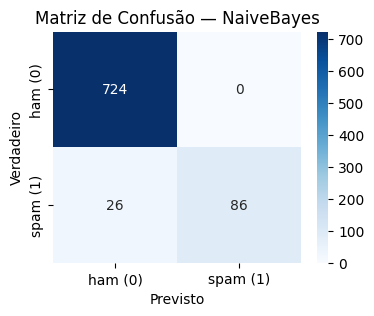

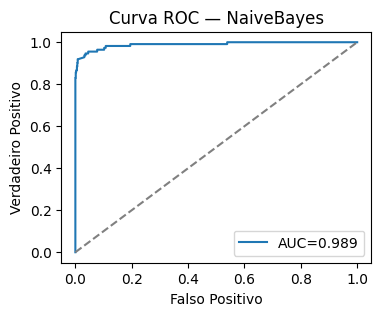

=== Treinando/Avaliando: LogReg ===


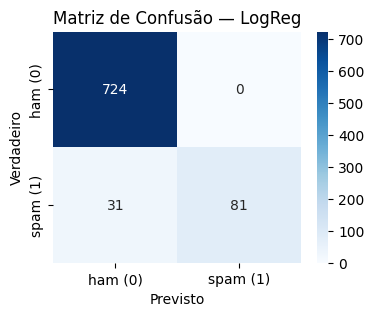

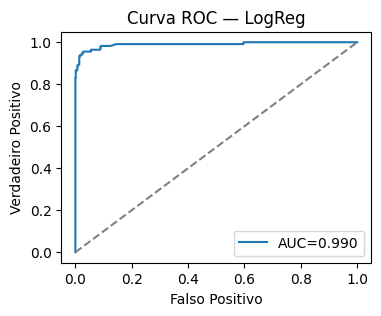

=== Treinando/Avaliando: LinearSVM ===


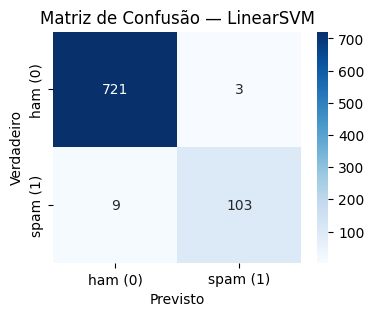

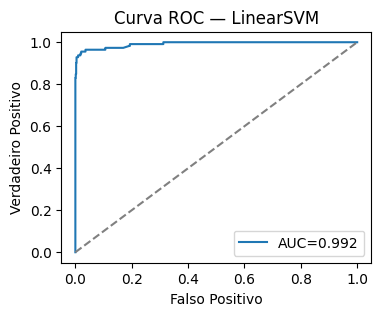

=== Treinando/Avaliando: RandomForest ===


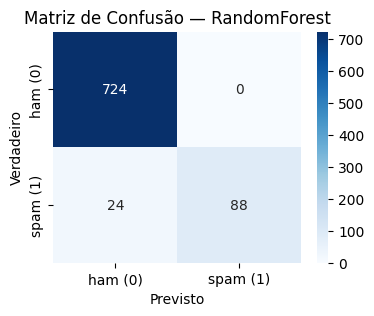

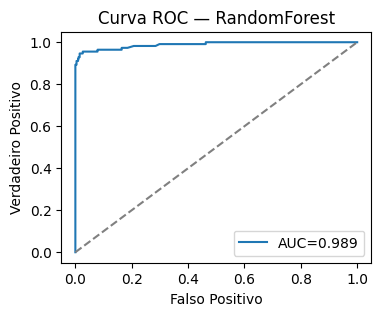

,Modelo,Accuracy,Precision,Recall,F1,AUC
2,LinearSVM,0.985646,0.971698,0.919643,0.944954,0.991892
3,RandomForest,0.971292,1.000000,0.785714,0.880000,0.988580
0,NaiveBayes,0.968900,1.000000,0.767857,0.868687,0.989252
1,LogReg,0.962919,1.000000,0.723214,0.839378,0.990066


In [19]:
import pandas as pd

results = []
for name, pipe in pipelines.items():
    print(f"=== Treinando/Avaliando: {name} ===")
    m = evaluate(pipe, X_train, y_train, X_val, y_val, name=name)
    results.append(m)

df_results = pd.DataFrame(results).sort_values(by="F1", ascending=False)
df_results


#Otimização de hiperparâmetros (GridSearchCV)  
Após identificar o SVM como um dos melhores modelos, aplicamos uma busca em grade (GridSearchCV) para otimizar seus hiperparâmetros.  
Foram testadas diferentes combinações de n-gramas no vetor TF-IDF, valores mínimos de frequência (`min_df`) e o parâmetro de regularização `C` do LinearSVC.  
A métrica utilizada para seleção foi o F1, dado que ela equilibra precisão e recall.  
O melhor modelo encontrado foi reavaliado na base de validação para confirmar sua performance.  


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros: {'model__estimator__C': 2, 'model__method': 'sigmoid', 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Melhor F1 (CV): 0.9500977554557901


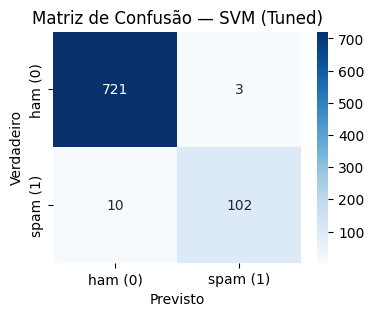

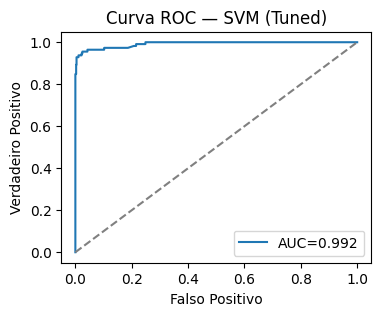

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "model__estimator__C": [0.5, 1, 2],
    "model__method": ["sigmoid"]
}

svm_calibrated = Pipeline([
    ("tfidf", tfidf),
    ("model", CalibratedClassifierCV(LinearSVC(), cv=3))
])

search = GridSearchCV(
    svm_calibrated,
    param_grid=grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
print("Melhores parâmetros:", search.best_params_)
print("Melhor F1 (CV):", search.best_score_)

best_svm = search.best_estimator_
_ = evaluate(best_svm, X_train, y_train, X_val, y_val, name="SVM (Tuned)")



#Avaliação final no conjunto de teste  
Após a escolha do melhor modelo, ele foi re-treinado utilizando a base de treino junto com a base de validação, aproveitando o máximo de dados disponíveis.  
Em seguida, foi avaliado no conjunto de teste, composto apenas por exemplos nunca vistos pelo modelo.  
Essa etapa fornece a estimativa mais realista de desempenho para o problema de classificação de mensagens spam vs. ham.  


=== Avaliação no TESTE ===


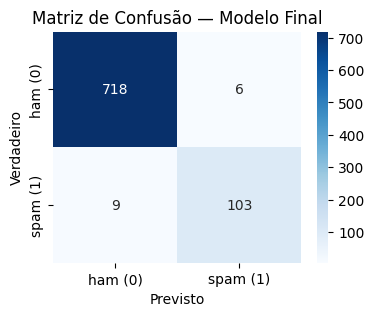

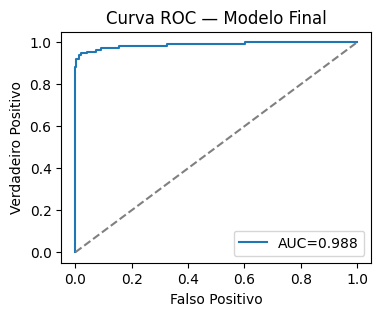

In [22]:
best_model = best_svm

X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_train_full, y_train_full)

print("=== Avaliação no TESTE ===")
_ = evaluate(best_model, X_train_full, y_train_full, X_test, y_test, name="Modelo Final")
